In [1]:
import os
import numpy as np
import anndata as ad
import scanpy as sc
import math
from masterthesis.data import load_h5ad

In [2]:
# load the python AnnData object
simdata_ann = load_h5ad("/home/julian/Uni/MasterThesis/data/simdata.h5ad")
print(simdata_ann.shape)

(573, 40916)


In [7]:
acinar_ann = load_h5ad("/home/julian/Uni/MasterThesis/data/acinar_sce.h5ad")
print(acinar_ann.shape)
# TODO: Convert float64 to float32 for handling by scanpy

(411, 23368)


## Preprocessing

### Filter Cells

In [4]:
# Notdone in psupertime??

### Select highly variable Genes

Logarithmizes and selects highly variably genes. `scanpy.pp.highly_variable_genes` expects logarithmized data.
Adds columns to `.var` (see [documentation](https://scanpy.readthedocs.io/en/stable/generated/scanpy.pp.highly_variable_genes.html) )

In [3]:
# selected Genes after preprocessing in R
sel_genes = ["REG3A", "AMY2A", "MT2A", "OLFM4",
             "SYCN", "CELA2B", "FGL1", "AMY2B",
             "MT1G", "TM4SF1", "CELA2A", "PDK4", 
             "TACSTD2", "CD44", "PNLIPRP2", "ALB", 
             "ERP27", "LDHA", "REG3G", "CTRL", "CLPS",
             "FOS", "HSPA8", "SERPINA3", "CELA3B", "CRP" ]

**Above list cannot be reproduced**

In [4]:
#sc.pp.log1p(acinar_ann, copy=False)

In [32]:
#sc.pp.normalize_per_cell(acinar_ann)

In [10]:
min_mean = 0.1  # Excludes gene mean values below this threshold. 0.1 is default for scran apparently

sc.pp.highly_variable_genes(acinar_ann, min_mean=min_mean, inplace=True)

In [9]:
acinar_ann.var.highly_variable[acinar_ann.var.highly_variable].shape

(2347,)

In [7]:
acinar_ann = acinar_ann[:, acinar_ann.var.highly_variable].copy()

# how effective was filtering?
print(acinar_ann.shape)

# All genes from R implementation still present?
print(sum([gene in acinar_ann.var_names for gene in sel_genes]))

(411, 3925)
26


### Filter Genes

Discard genes only expressed in a small number (1%) of cells

In [8]:
cell_thresh = math.ceil(0.01 * acinar_ann.n_obs)

In [9]:
cell_thresh = math.ceil(0.01 * acinar_ann.n_obs)
sc.pp.filter_genes(acinar_ann, min_cells=cell_thresh, inplace=True)

In [10]:
acinar_ann

AnnData object with n_obs × n_vars = 411 × 3925
    obs: 'wellKey', 'geo_accession', 'donor_age', 'gender', 'inferred_cell_type'
    var: 'primerid', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells'
    uns: 'X_name', 'log1p', 'hvg'
    layers: 'counts', 'tpm'

In [11]:
# All genes from R implementation still present?
sum([gene in acinar_ann.var_names for gene in sel_genes])

26

### Filter Genes
Exclude any genes with zero SD


### Denoising / Dropout correction

Mean over 10 highest correlated observations / cells

In [13]:
# TODO
pass

### Scaling

Normalization (mean = 0, std = 1)

In [14]:
### Scaling

# Normalization (mean = 0, std = 1)

# TODO
sc.pp.scale(acinar_ann)

## Compare to the wrapped code

In [3]:
from masterthesis.preprocessing import Preprocessing

In [4]:
pp = Preprocessing(log=False, normalize=False, select_genes="hvg")
adata = pp.fit_transform(acinar_ann)

In [6]:
adata

AnnData object with n_obs × n_vars = 411 × 1755
    obs: 'wellKey', 'geo_accession', 'donor_age', 'gender', 'inferred_cell_type'
    var: 'primerid', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'X_name', 'hvg'
    layers: 'counts', 'tpm'

## Simdata

In [38]:
sc.pp.log1p(simdata_ann, copy=False)
sc.pp.normalize_per_cell(simdata_ann)
sc.pp.highly_variable_genes(simdata_ann, min_mean=min_mean, span=1, inplace=True)
sim_processed = simdata_ann[:, simdata_ann.var.highly_variable].copy()

In [44]:
sim_processed.shape

(573, 6157)

In [42]:
from sklearn.model_selection import train_test_split

simy = np.array([int(x) for x in sim_processed.obs.Ordinal_Time_Labels])
k = len(np.unique(y))
simX_train, simX_test, simy_train, simy_test = train_test_split(sim_processed.X, simy, 
                                                    test_size=0.1, 
                                                    stratify=simy,
                                                    random_state=1234)

# Transform y into a series of subsequent labels [0,1,2 ...]
transf = dict(zip(np.unique(simy),
                  np.arange(0, len(np.unique(simy)))))

simy_train_trans = np.array([transf[e] for e in simy_train])
simy_test_trans = np.array([transf[e] for e in simy_test])

# sample weighting
_, train_cts = np.unique(y_train_trans, return_counts=True)
_, test_cts = np.unique(y_test_trans, return_counts=True)

sim_weights_train = [train_cts[el] / len(simy_train_trans) for el in simy_train_trans]
sim_weights_test = [test_cts[el] / len(simy_test_trans) for el in simy_test_trans]

# Sim Model

In [45]:
from masterthesis.model import SGDBinarizedModel
from masterthesis.model_selection import RegularizationGridSearch

cv = RegularizationGridSearch(SGDBinarizedModel).fit(simX_train, simy_train_trans)


(10.0, 0)
Train Accuracy: 0.1029126213592233
Train Balanced accuracy 0.14285714285714285
Train Mean absolute delta: 2.584395503364119
Test Accuracy: 0.10344827586206896
Test Balanced accuracy 0.14285714285714285
Test Mean absolute delta: 2.5857605177993532


Text(0.5, 0.98, 'Linear Binarized Model (best cv-score)')

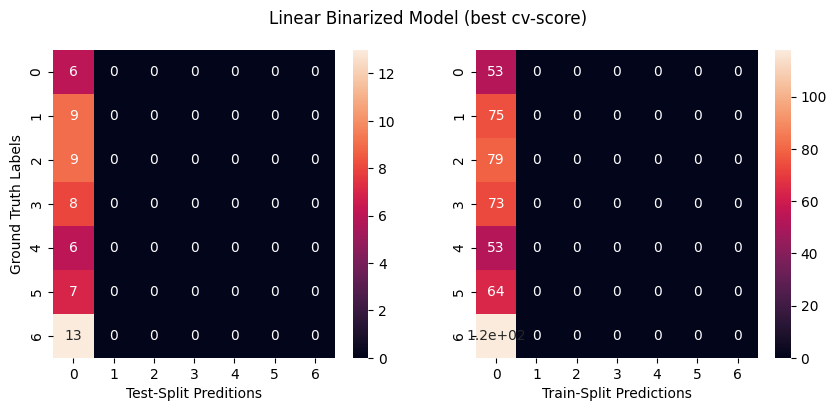

In [48]:
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns

print(cv.get_optimal_lambda())
sgd_model = cv.get_optimal_model("1se")
sgd_model.fit(simX_train, simy_train_trans)

print("Train Accuracy:", metrics.accuracy_score(simy_train_trans, sgd_model.predict(simX_train)))
print("Train Balanced accuracy", metrics.balanced_accuracy_score(simy_train_trans, sgd_model.predict(simX_train), sample_weight=sim_weights_train))
print("Train Mean absolute delta:", metrics.mean_absolute_error(simy_train_trans, sgd_model.predict(simX_train), sample_weight=sim_weights_train))

print("Test Accuracy:", metrics.accuracy_score(simy_test_trans, sgd_model.predict(simX_test)))
print("Test Balanced accuracy", metrics.balanced_accuracy_score(simy_test_trans, sgd_model.predict(simX_test), sample_weight=sim_weights_test))
print("Test Mean absolute delta:", metrics.mean_absolute_error(simy_test_trans, sgd_model.predict(simX_test), sample_weight=sim_weights_test))


fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.heatmap(metrics.confusion_matrix(simy_test_trans, sgd_model.predict(simX_test)), annot=True, ax=ax1)
sns.heatmap(metrics.confusion_matrix(simy_train_trans, sgd_model.predict(simX_train)), annot=True, ax=ax2)

ax1.set_xlabel("Test-Split Preditions")
ax1.set_ylabel("Ground Truth Labels")
ax2.set_xlabel("Train-Split Predictions")

fig.suptitle("Linear Binarized Model (best cv-score)")

# Model

In [15]:
from sklearn.model_selection import train_test_split

y = np.array([int(x) for x in acinar_copy.obs.donor_age])
k = len(np.unique(y))
X_train, X_test, y_train, y_test = train_test_split(acinar_copy.X, y, 
                                                    test_size=0.1, 
                                                    stratify=y,
                                                    random_state=1234)

# Transform y into a series of subsequent labels [0,1,2 ...]
transf = dict(zip(np.unique(y),
                  np.arange(0, len(np.unique(y)))))

y_train_trans = np.array([transf[e] for e in y_train])
y_test_trans = np.array([transf[e] for e in y_test])

# sample weighting
_, train_cts = np.unique(y_train_trans, return_counts=True)
_, test_cts = np.unique(y_test_trans, return_counts=True)

weights_train = [train_cts[el] / len(y_train_trans) for el in y_train_trans]
weights_test = [test_cts[el] / len(y_test_trans) for el in y_test_trans]

In [16]:
from masterthesis.model import SGDBinarizedModel
from masterthesis.model_selection import RegularizationGridSearch

cv = RegularizationGridSearch(SGDBinarizedModel).fit(X_train, y_train_trans)


Best idx: 36 Best Score: 3.503554239170677 Best Lambda: 0.0021209508879201904 Scores std: 0.24919203242634644
1SE idx: 36 1SE Score: 3.503554239170677 1SE Lambda: 0.0021209508879201904


Text(0.5, 0.98, 'Linear binarized Model training')

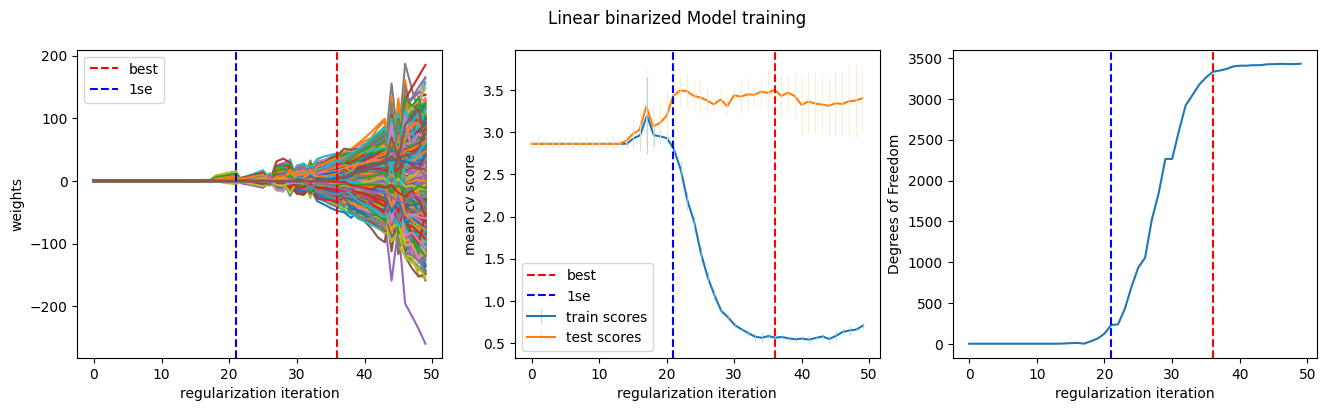

In [23]:

best_lambda, best_idx = cv.get_optimal_lambda("best")
print("Best idx:", best_idx, "Best Score:", cv.scores[best_idx], "Best Lambda:", cv.lambdas[best_idx], "Scores std:", np.std(cv.scores))
ose_lambda, ose_idx = cv.get_optimal_lambda("1se")
print("1SE idx:", best_idx, "1SE Score:", cv.scores[best_idx], "1SE Lambda:", cv.lambdas[best_idx])

fig = plt.figure(figsize=(16,4))

ax1 = fig.add_subplot(131)
fitted_weights = np.array([e.coef_ for e in cv.fitted_estimators])
ax1.plot(fitted_weights)
ax1.axvline(best_idx, ymin=0, ymax=1, color="red", label="best", ls="--")
ax1.axvline(ose_idx, ymin=0, ymax=1, color="blue", label="1se", ls="--")
ax1.set_xlabel("regularization iteration")
ax1.set_ylabel("weights")
#ax1.set_yscale("log")
ax1.legend()

ax3 = fig.add_subplot(132)
ax3.errorbar(x=np.arange(len(cv.train_scores))+0.1, y=cv.train_scores, yerr=cv.train_scores_std, elinewidth=0.5, color="tab:blue", ecolor="skyblue", barsabove=True, label="train scores")
ax3.errorbar(x=np.arange(len(cv.scores)), y=cv.scores, yerr=cv.scores_std, elinewidth=0.5, color="tab:orange", ecolor="moccasin", barsabove=True, label="test scores")
ax3.axvline(best_idx, ymin=0, ymax=1, color="red", label="best", ls="--")
ax3.axvline(ose_idx, ymin=0, ymax=1, color="blue", label="1se", ls="--")
ax3.set_xlabel("regularization iteration")
ax3.set_ylabel("mean cv score")
ax3.legend()

ax2 = fig.add_subplot(133)
ax2.plot(cv.dof)
ax2.axvline(best_idx, ymin=0, ymax=1, color="red", label="best", ls="--")
ax2.axvline(ose_idx, ymin=0, ymax=1, color="blue", label="1se", ls="--")
ax2.set_xlabel("regularization iteration")
ax2.set_ylabel("Degrees of Freedom")

fig.suptitle("Linear binarized Model training")

(0.07196856730011521, 21)
Train Accuracy: 0.17073170731707318
Train Balanced accuracy 0.18239795918367346
Train Mean absolute delta: 2.530307593030759
Test Accuracy: 0.07142857142857142
Test Balanced accuracy 0.08125000000000002
Test Mean absolute delta: 3.1891891891891895


Text(0.5, 0.98, 'Linear Binarized Model (best cv-score)')

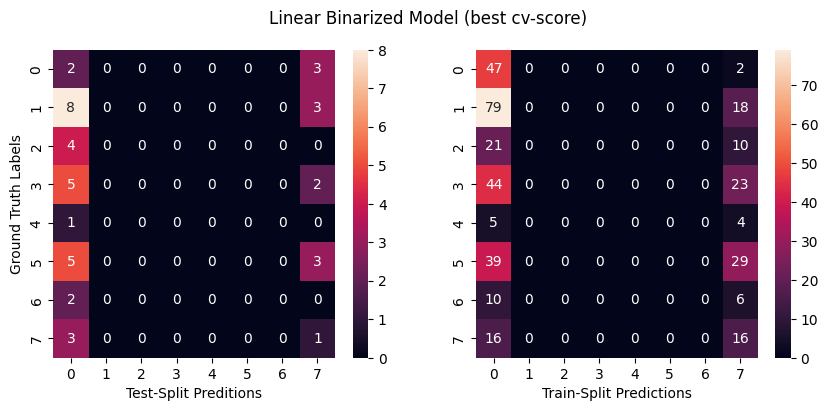

In [24]:
from sklearn import metrics
from matplotlib import pyplot as plt
import seaborn as sns

print(cv.get_optimal_lambda())
sgd_model = cv.get_optimal_model("1se")
sgd_model.fit(X_train, y_train_trans)

print("Train Accuracy:", metrics.accuracy_score(y_train_trans, sgd_model.predict(X_train)))
print("Train Balanced accuracy", metrics.balanced_accuracy_score(y_train_trans, sgd_model.predict(X_train), sample_weight=weights_train))
print("Train Mean absolute delta:", metrics.mean_absolute_error(y_train_trans, sgd_model.predict(X_train), sample_weight=weights_train))

print("Test Accuracy:", metrics.accuracy_score(y_test_trans, sgd_model.predict(X_test)))
print("Test Balanced accuracy", metrics.balanced_accuracy_score(y_test_trans, sgd_model.predict(X_test), sample_weight=weights_test))
print("Test Mean absolute delta:", metrics.mean_absolute_error(y_test_trans, sgd_model.predict(X_test), sample_weight=weights_test))


fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

sns.heatmap(metrics.confusion_matrix(y_test_trans, sgd_model.predict(X_test)), annot=True, ax=ax1)
sns.heatmap(metrics.confusion_matrix(y_train_trans, sgd_model.predict(X_train)), annot=True, ax=ax2)

ax1.set_xlabel("Test-Split Preditions")
ax1.set_ylabel("Ground Truth Labels")
ax2.set_xlabel("Train-Split Predictions")

fig.suptitle("Linear Binarized Model (best cv-score)")